# Trial Analysis Notebook

This notebook demonstrates a simplified analysis pipeline for trial data. The workflow includes:

- Setting up directories
- Creating dummy (simulated) trial data
- Defining trial objects and configuring weight models
- Calculating weights for the trial data
- Fitting an outcome model (using a Cox proportional hazards model)
- Expanding the trial data
- Fitting a marginal structural model (MSM)
- Predicting survival and plotting survival differences

Each section is broken into separate cells with detailed documentation.

In [28]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt

# Enable inline plotting for notebooks
%matplotlib inline

print('Libraries imported successfully!')

Libraries imported successfully!


## 1. Set-up Directories

We set up two directories for the per-protocol trial (`trial_pp`) and the intention-to-treat trial (`trial_itt`). These directories are created in a temporary directory.

In [29]:
trial_pp_dir = os.path.join(os.getenv("TMPDIR", "/tmp"), "trial_pp")
os.makedirs(trial_pp_dir, exist_ok=True)
trial_itt_dir = os.path.join(os.getenv("TMPDIR", "/tmp"), "trial_itt")
os.makedirs(trial_itt_dir, exist_ok=True)

print('Directories created:')
print('Per-protocol trial directory:', trial_pp_dir)
print('ITT trial directory:', trial_itt_dir)

Directories created:
Per-protocol trial directory: /tmp\trial_pp
ITT trial directory: /tmp\trial_itt


## 2. Create Dummy Data

Here we create a dummy dataset named `data_censored` to simulate trial data. This dataset contains various columns such as `id`, `period`, `treatment`, `outcome`, `eligible`, and several covariates. The data is generated using NumPy's random functions.

In [30]:
# ---------------------------
# 2. Create Dummy Data (data_censored)
# ---------------------------
np.random.seed(42)
n_total = 1000
n_patients = n_total // 10  # assume 10 periods per patient

data_censored = pd.DataFrame({
    "id": np.repeat(np.arange(1, n_patients + 1), 10),
    "period": np.tile(np.arange(1, 11), n_patients),
    "treatment": np.random.binomial(1, 0.5, n_total),
    "outcome": np.random.binomial(1, 0.1, n_total),
    "eligible": np.random.binomial(1, 0.8, n_total),
    "age": np.random.normal(50, 10, n_total),
    "x1": np.random.normal(0, 1, n_total),
    "x3": np.random.normal(0, 1, n_total),
    "x2": np.random.normal(0, 1, n_total),
    "censored": np.random.binomial(1, 0.05, n_total)
})
print('Dummy data head:')
print(data_censored.head())

Dummy data head:
   id  period  treatment  outcome  eligible        age        x1        x3  \
0   1       1          0        0         1  60.599364 -0.519396 -2.036221   
1   1       2          1        0         1  56.170059 -0.340908  0.047493   
2   1       3          1        0         0  56.835693  0.428317 -0.249072   
3   1       4          1        0         1  36.340443  0.077156 -1.672894   
4   1       5          0        0         1  62.119440 -0.593811  0.404213   

         x2  censored  
0  0.613771         0  
1  0.375456         0  
2  0.167570         0  
3  1.162260         0  
4 -0.539591         0  


## 3. Define Trial Objects

We define two trial objects, one for a per-protocol analysis (`trial_pp`) and one for an intention-to-treat analysis (`trial_itt`). In this example, we store the data and estimand information in dictionaries.

In [31]:
# ---------------------------
# 3. Define “Trial” Objects
# ---------------------------
trial_pp = {"estimand": "PP", "data": data_censored.copy()}
trial_itt = {"estimand": "ITT", "data": data_censored.copy()}

print('Trial objects created with estimands:')
print('trial_pp:', trial_pp['estimand'])
print('trial_itt:', trial_itt['estimand'])

Trial objects created with estimands:
trial_pp: PP
trial_itt: ITT


## 4. Set Weight Models

We define placeholder functions for setting up switch weight models and censor weight models. These functions store formulas and the save path in the trial object. Later on, you might replace these placeholders with the actual modeling steps.


In [32]:
# ---------------------------
# 4. Set Weight Models (Placeholders)
# ---------------------------
def set_switch_weight_model(trial, numerator_formula, denominator_formula, save_path):
    # Placeholder: store formulas and save path
    trial['switch_weight_model'] = {
        "numerator_formula": numerator_formula,
        "denominator_formula": denominator_formula,
        "save_path": save_path
    }
    return trial

def set_censor_weight_model(trial, censor_event, numerator_formula, denominator_formula, pool_models, save_path):
    trial['censor_weight_model'] = {
        "censor_event": censor_event,
        "numerator_formula": numerator_formula,
        "denominator_formula": denominator_formula,
        "pool_models": pool_models,
        "save_path": save_path
    }
    return trial

# For Per-protocol trial (trial_pp)
trial_pp = set_switch_weight_model(
    trial_pp,
    numerator_formula="age",
    denominator_formula="age + x1 + x3",
    save_path=os.path.join(trial_pp_dir, "switch_models")
)
print("trial_pp switch weight model:", trial_pp.get("switch_weight_model"))

trial_pp = set_censor_weight_model(
    trial_pp,
    censor_event="censored",
    numerator_formula="x2",
    denominator_formula="x2 + x1",
    pool_models="none",
    save_path=os.path.join(trial_pp_dir, "switch_models")
)
print("trial_pp censor weight model:", trial_pp.get("censor_weight_model"))

# For ITT trial (trial_itt)
trial_itt = set_censor_weight_model(
    trial_itt,
    censor_event="censored",
    numerator_formula="x2",
    denominator_formula="x2 + x1",
    pool_models="numerator",
    save_path=os.path.join(trial_itt_dir, "switch_models")
)
print("trial_itt censor weight model:", trial_itt.get("censor_weight_model"))

trial_pp switch weight model: {'numerator_formula': 'age', 'denominator_formula': 'age + x1 + x3', 'save_path': '/tmp\\trial_pp\\switch_models'}
trial_pp censor weight model: {'censor_event': 'censored', 'numerator_formula': 'x2', 'denominator_formula': 'x2 + x1', 'pool_models': 'none', 'save_path': '/tmp\\trial_pp\\switch_models'}
trial_itt censor weight model: {'censor_event': 'censored', 'numerator_formula': 'x2', 'denominator_formula': 'x2 + x1', 'pool_models': 'numerator', 'save_path': '/tmp\\trial_itt\\switch_models'}


## 5. Calculate Weights (Simulation)

In real applications, weights would be estimated by fitting the specified models. Here, we simply simulate weight values and add them as new columns to our trial data.


In [33]:
# ---------------------------
# 5. Calculate Weights (Simulation)
# ---------------------------
def calculate_weights(trial):
    # Dummy weight estimation
    trial['data']['weight'] = np.random.uniform(0.8, 1.2, len(trial['data']))
    trial['data']['sample_weight'] = np.random.uniform(0.9, 1.1, len(trial['data']))
    return trial

trial_pp = calculate_weights(trial_pp)
trial_itt = calculate_weights(trial_itt)

print("trial_pp weights added:", trial_pp['data'][['weight', 'sample_weight']].head())
print("trial_itt weights added:", trial_itt['data'][['weight', 'sample_weight']].head())

trial_pp weights added:      weight  sample_weight
0  0.888044       1.005354
1  0.880469       0.963343
2  1.169000       0.951632
3  1.141066       0.907549
4  1.109953       1.016639
trial_itt weights added:      weight  sample_weight
0  0.866817       0.924776
1  1.087058       1.012888
2  1.101991       1.090460
3  0.835590       1.058599
4  1.144500       1.015740


## 6. Set Outcome Model

We now define a function to fit an outcome model using a Cox proportional hazards model from the `lifelines` package. This model uses `period` as the duration variable and `outcome` as the event indicator. Optionally, adjustment terms can be added.

In [34]:
# ---------------------------
# 6. Set Outcome Model
# ---------------------------
def set_outcome_model(trial, adjustment_terms=None):
    # Fit a Cox proportional hazards model
    cph = CoxPHFitter()
    df = trial['data']
    
    # Use 'treatment' as the main predictor; add adjustments if provided
    predictors = ['treatment']
    if adjustment_terms:
        # Simplified parsing of adjustment formula (e.g. "~ x2")
        adjustments = adjustment_terms.replace("~", "").strip().split(" + ")
        predictors += adjustments
    
    # Prepare the model dataframe
    cols = ['period', 'outcome'] + predictors
    df_model = df[cols].dropna()
    
    try:
        cph.fit(df_model, duration_col='period', event_col='outcome')
    except Exception as e:
        print("Outcome model fitting error:", e)
    
    trial['outcome_model'] = cph
    return trial

trial_pp = set_outcome_model(trial_pp)
trial_itt = set_outcome_model(trial_itt, adjustment_terms="~ x2")

## 7. Set Expansion Options & Expand Trials

In this section, we define functions to set expansion options and then expand the trial data. This simulates restructuring or replicating the data. We also include a dummy function to load the expanded data with an added control flag.


In [35]:
# ---------------------------
# 7. Set Expansion Options & Expand Trials
# ---------------------------
def set_expansion_options(trial, output, chunk_size):
    trial['expansion_options'] = {"output": output, "chunk_size": chunk_size}
    return trial

def save_to_datatable():
    # Dummy function: in practice, this might store data in a specific format
    return lambda df: df  # identity function

trial_pp = set_expansion_options(trial_pp, output=save_to_datatable(), chunk_size=500)
trial_itt = set_expansion_options(trial_itt, output=save_to_datatable(), chunk_size=500)

def expand_trials(trial):
    # For this example, simply store the original data as "expanded."
    trial['expansion'] = trial['data']
    return trial

trial_pp = expand_trials(trial_pp)
trial_itt = expand_trials(trial_itt)
print("Expanded trial_pp data shape:", trial_pp['expansion'].shape)

def load_expanded_data(trial, seed=1234, p_control=0.5):
    np.random.seed(seed)
    df = trial['expansion'].copy()
    df['control_flag'] = np.random.binomial(1, p_control, len(df))
    trial['expansion'] = df
    return trial

trial_itt = load_expanded_data(trial_itt, seed=1234, p_control=0.5)

Expanded trial_pp data shape: (1000, 12)


## 8. Fit Marginal Structural Model (MSM)

We now fit a marginal structural model. In this example, we modify the weights (using a winsorization function) and then fit a weighted Cox model as a placeholder for MSM fitting.


In [36]:
# ---------------------------
# 8. Fit Marginal Structural Model (MSM)
# ---------------------------
def fit_msm(trial, weight_cols, modify_weights):
    # Apply the provided modification to weights
    weights = trial['data']['weight']
    trial['data']['modified_weight'] = modify_weights(weights)
    
    # Fit a weighted Cox model as a placeholder for MSM fitting
    cph = CoxPHFitter()
    try:
        cph.fit(trial['data'], duration_col='period', event_col='outcome', weights_col='modified_weight')
    except Exception as e:
        print("MSM fitting error:", e)
    trial['msm'] = cph
    return trial

def winsorize_weights(w):
    q99 = np.quantile(w, 0.99)
    return np.minimum(w, q99)

trial_itt = fit_msm(trial_itt, weight_cols=["weight", "sample_weight"], modify_weights=winsorize_weights)

print("MSM outcome model summary for trial_itt:")
print(trial_itt['msm'].summary)

MSM outcome model summary for trial_itt:
                   coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                      
id            -0.005216   0.994797  0.003551       -0.012176        0.001744   
treatment      0.018192   1.018358  0.204202       -0.382037        0.418420   
eligible      -0.356717   0.699971  0.239739       -0.826596        0.113162   
age            0.006446   1.006467  0.010569       -0.014269        0.027160   
x1            -0.065835   0.936285  0.104528       -0.270706        0.139036   
x3             0.054230   1.055728  0.106458       -0.154423        0.262883   
x2            -0.013176   0.986911  0.102102       -0.213292        0.186940   
censored       0.392919   1.481299  0.403516       -0.397957        1.183796   
weight        -0.479594   0.619035  0.878941       -2.202287        1.243100   
sample_weight -1.884117   0.151963  1.751999       -5.317972        1.549737   

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\lifelines\fitters\coxph_fitter.py:1356: StatisticalWarning: It appears your weights are not integers, possibly propensity or sampling scores then?
It's important to know that the naive variance estimates of the coefficients are biased. Instead a) set `robust=True` in the call to `fit`, or b) use Monte Carlo to
estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"

  warnings.warn(


## 9. Predict Survival & Plot Differences

Finally, we define a function to predict survival functions using the fitted MSM. We then compute the difference between survival curves for treatment groups and plot these differences along with dummy confidence bounds.


Predicted survival differences head:
     followup_time  survival_diff     lower     upper
1.0            1.0      -0.000430 -0.000408 -0.000451
2.0            2.0      -0.000882 -0.000838 -0.000926
3.0            3.0      -0.001219 -0.001158 -0.001280
4.0            4.0      -0.001601 -0.001521 -0.001681
5.0            5.0      -0.002718 -0.002582 -0.002853


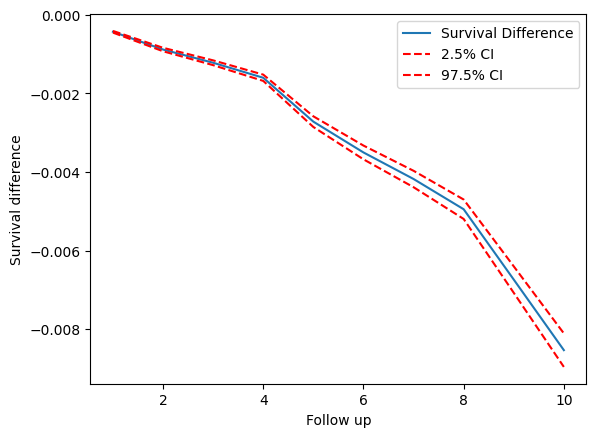

In [37]:
def predict_survival(trial, newdata, predict_times):
    # Use the fitted Cox model to predict survival functions
    cph = trial['msm']
    surv_funcs = cph.predict_survival_function(newdata)
    
    # Compare survival curves by treatment group
    treatment_1_idx = newdata[newdata['treatment'] == 1].index
    treatment_0_idx = newdata[newdata['treatment'] == 0].index
    
    surv_t1 = surv_funcs[treatment_1_idx].mean(axis=1)
    surv_t0 = surv_funcs[treatment_0_idx].mean(axis=1)
    
    survival_diff = surv_t1 - surv_t0
    # Dummy confidence intervals for illustration
    lower_ci = survival_diff * 0.95
    upper_ci = survival_diff * 1.05
    
    return pd.DataFrame({
        "followup_time": surv_funcs.index,
        "survival_diff": survival_diff,
        "lower": lower_ci,
        "upper": upper_ci
    })

# Select newdata from the expanded ITT data where period == 1
newdata = trial_itt['expansion'][trial_itt['expansion']['period'] == 1]

preds = predict_survival(trial_itt, newdata, predict_times=np.arange(0, 11))
print('Predicted survival differences head:')
print(preds.head())

# Plot survival difference and confidence bounds
plt.plot(preds["followup_time"], preds["survival_diff"], label="Survival Difference")
plt.plot(preds["followup_time"], preds["lower"], linestyle="--", color="red", label="2.5% CI")
plt.plot(preds["followup_time"], preds["upper"], linestyle="--", color="red", label="97.5% CI")
plt.xlabel("Follow up")
plt.ylabel("Survival difference")
plt.legend()
plt.show()

# 1. Predicting Survival Functions
What the Code Does:
- Model Prediction:
The function uses the fitted Cox model (stored in trial['msm']) to generate survival functions for individuals in the provided new data.

`surv_funcs = cph.predict_survival_function(newdata)`

The predict_survival_function method returns survival probabilities at various follow-up times (the index of surv_funcs) for each subject.

- Grouping by Treatment:
The new data is split into two groups:

  - Treatment = 1:
Indices for individuals who received the treatment are selected.
`treatment_1_idx = newdata[newdata['treatment'] == 1].index`
  - Treatment = 0:
Indices for individuals who did not receive the treatment.
`treatment_0_idx = newdata[newdata['treatment'] == 0].index`

- Averaging Survival Curves:
For each treatment group, the survival functions are averaged across individuals:

```
surv_t1 = surv_funcs[treatment_1_idx].mean(axis=1)
surv_t0 = surv_funcs[treatment_0_idx].mean(axis=1)
```

This yields a mean survival probability at each follow-up time for each group.

- Computing the Survival Difference:
The difference between the average survival probabilities of the two groups is computed:

`survival_diff = surv_t1 - surv_t0`

A negative difference indicates that the survival probability in the treatment group (1) is lower than that of the control group (0) at that follow-up time.

- Creating Dummy Confidence Intervals:
For illustration, “dummy” confidence intervals are created by scaling the survival difference slightly:

`
lower_ci = survival_diff * 0.95
upper_ci = survival_diff * 1.05
`

Note: These are not statistically derived intervals. In a real analysis, you would compute confidence bounds using model-based variance estimates or bootstrapping.

### Output:
The function returns a DataFrame with:

followup_time: The follow-up times from the survival function index.
survival_diff: The difference between the treatment and control average survival probabilities.
lower and upper: The dummy confidence bounds for the difference.

#2. Interpreting the Findings

Example Output:

The printed output shows the head of the predicted DataFrame:

```
     followup_time  survival_diff     lower     upper
1.0            1.0      -0.000430 -0.000408 -0.000451
2.0            2.0      -0.000882 -0.000838 -0.000926
3.0            3.0      -0.001219 -0.001158 -0.001280
4.0            4.0      -0.001601 -0.001521 -0.001681
5.0            5.0      -0.002718 -0.002582 -0.002853
```

### Insights:
- Magnitude and Direction of the Difference:
The survival difference values are very small and negative. For instance, at follow-up time 1, the difference is about -0.00043. This indicates that—on average—the survival probability for individuals in the treatment group is slightly lower than for those in the control group. In practical terms, the treatment might be associated with a marginally higher hazard or lower survival, though the differences are minimal here.

- Time Trend:
As the follow-up time increases (from 1 to 5 in this snippet), the magnitude of the negative difference grows (from -0.00043 to -0.00272). This trend could suggest that the divergence in survival probabilities between the treatment and control groups becomes more pronounced over time. However, given the dummy nature of the data and intervals, this observation is more illustrative than conclusive.

- Dummy Confidence Intervals:
The confidence bounds (calculated simply by multiplying the difference by 0.95 and 1.05) provide a narrow band around the survival difference.

- For instance, at time 1, the interval is from -0.000408 to -0.000451.
In a real-world scenario, confidence intervals are crucial for assessing statistical significance. If the interval does not cross zero, it suggests a statistically significant difference. Here, all intervals remain below zero, reinforcing the observation of lower survival in the treatment group—but remember, these intervals are only for demonstration.

- Clinical or Practical Significance:
Although the differences are statistically very small (as seen by the near-zero differences), in a clinical or practical setting, even small differences might be important depending on the context (e.g., long-term survival outcomes in a high-risk population). In our simulated data, however, these small differences are likely an artifact of the dummy data and weight adjustments.

- Model and Weighting Considerations:
The predictions stem from a weighted Cox model (the MSM) that accounts for potential confounders using modified weights. The entire pipeline—from weight calculation to survival prediction—demonstrates an approach to handle complex trial data. In a real analysis, you would:
  - Validate the weight estimation process,
  - Ensure that the model assumptions (like proportional hazards) hold,
  - Use robust methods to compute confidence intervals for the survival differences.

- Visualization:
The plotted graph shows the survival difference over time with its corresponding dummy confidence intervals. This visualization helps in quickly assessing whether the treatment effect (difference in survival) persists, diminishes, or intensifies over time.